# Анализ данных в задаче кредитного скоринга

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import scipy
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.proportion import proportion_confint
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

### Загрузим данные и сразу приведем в порядок бинарные и категориальные признаки

In [2]:
credit = pd.read_csv('credit_card_default_analysis.csv')
credit.SEX -= 1
credit

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,1,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,1,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,1,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,1,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,0,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,0,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,0,3,2,43,0,0,0,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,0,2,2,37,4,3,2,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,0,3,1,41,1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


# Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 
- a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 
- b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

### Подзадача (a)
* H0: медианные значения равны
* H1: медианные значения отличаются

Сначала просто взглянем на гистограммы данных и попробуем понять, как именно распределены значения в данных. И посчитаем точечные оценки медиан выборок

Медиана кредитного лимита тех, кто отдает кредиты: 150000.0
Медиана кредитного лимита тех, кто НЕ отдает кредиты: 90000.0


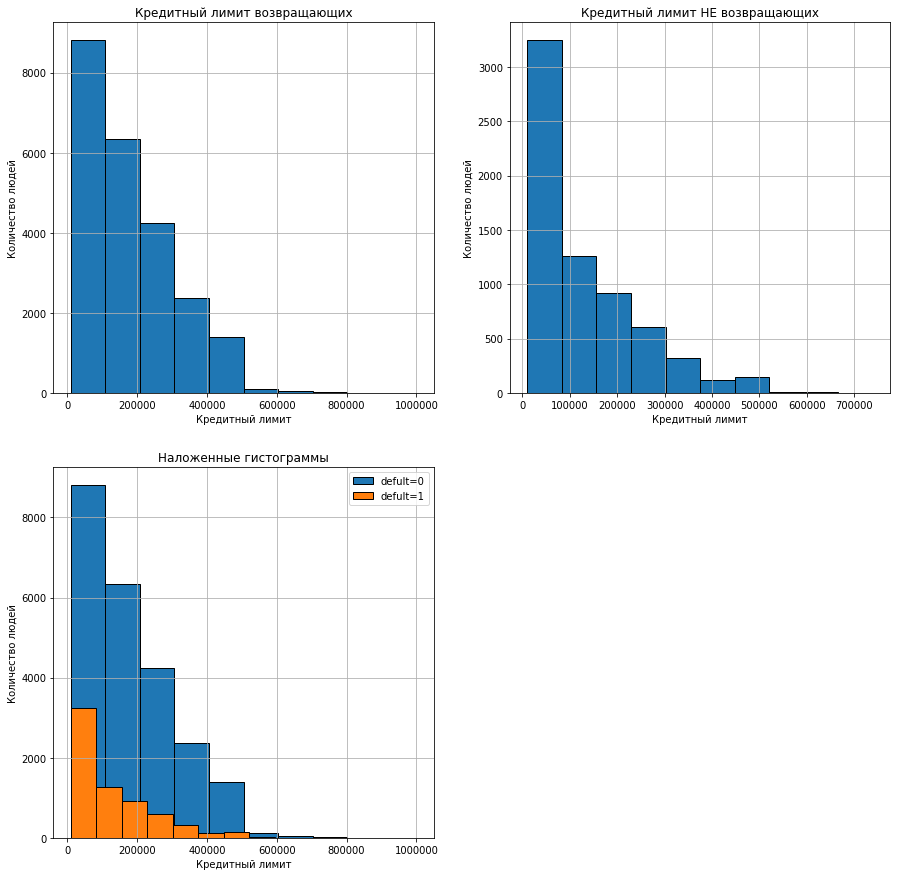

In [3]:
credit_default_0 = credit[credit.default == 0].LIMIT_BAL
credit_default_1 = credit[credit.default == 1].LIMIT_BAL
m0 = credit_default_0.median()
m1 = credit_default_1.median()
print('Медиана кредитного лимита тех, кто отдает кредиты:', m0)
print('Медиана кредитного лимита тех, кто НЕ отдает кредиты:', m1)

plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.hist(credit_default_0, edgecolor='k')
plt.xlabel('Кредитный лимит')
plt.ylabel('Количество людей')
plt.title('Кредитный лимит возвращающих')
plt.grid()

plt.subplot(2,2,2)
plt.hist(credit_default_1, edgecolor='k')
plt.xlabel('Кредитный лимит')
plt.ylabel('Количество людей')
plt.title('Кредитный лимит НЕ возвращающих')
plt.grid()

plt.subplot(2,2,3)
plt.hist(credit_default_0, edgecolor='k', label='defult=0')
plt.hist(credit_default_1, edgecolor='k', label='defult=1')
plt.xlabel('Кредитный лимит')
plt.ylabel('Количество людей')
plt.title('Наложенные гистограммы')
plt.legend()
plt.grid()

In [4]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [5]:
credit_default_medians_0 = list(map(np.median, get_bootstrap_samples(credit_default_0.values, 1000)))
credit_default_medians_1 = list(map(np.median, get_bootstrap_samples(credit_default_1.values, 1000)))

print ("95% confidence interval for the default=0 median limit:",  stat_intervals(credit_default_medians_0))
print ("95% confidence interval for the default=1 median limit:",  stat_intervals(credit_default_medians_1))

95% confidence interval for the default=0 median limit: [150000. 150000.]
95% confidence interval for the default=1 median limit: [80000. 90000.]


### Ответ a)
- Гипотеза о равенстве медианных значений для людей, которые возвращают кредиты не отвергается, так как доверительный интервал для медианы лежит в одной точке
- Гипотеза о равенстве медианных значений для людей, которые НЕ возвращают кредиты отвергается, так как доверительный интервал для медианы лежит в [80000 : 90000], а значит медиана кредитного лимита для этих людей лежит левее

### Подзадача (b)
* H0: Выборки получены из одного распределения
* H1: Распределения выборок различаются сдвигом

Чтобы визуально понять, могут ли быть теоретически выборки взяты из одного распределения, построим QQ-plot, а потом используем перестановочный критерий для независимых выборок, чтобы проверить гипотезу о равенстве распределений

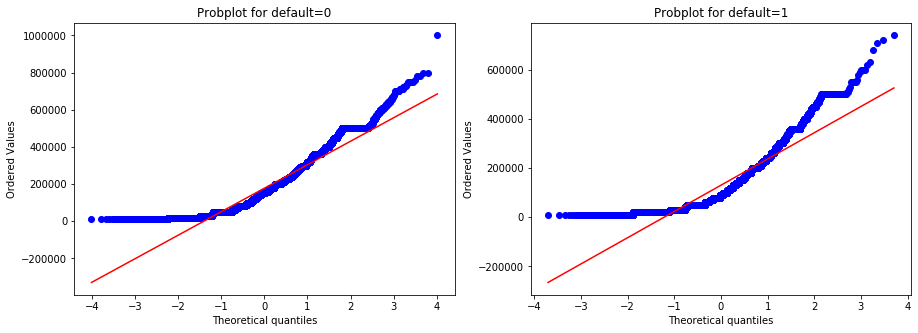

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

stats.probplot(credit_default_0, plot=ax1)
ax1.title.set_text('Probplot for default=0')
stats.probplot(credit_default_1, plot=ax2)
ax2.title.set_text('Probplot for default=1')

Как видим, графики очень похожи, так что скорее всего гипотеза H1 будет верна, распределения различаются на сдвиг

In [7]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample1, sample2, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [8]:
print('Достигаемые уровни значимости при изменении количества перестановок:', end='\n\n')
for i in range(100, 1001, 100):
    print('\tp = {},\t max permutations = {}'.format(np.round(permutation_test(credit_default_0, credit_default_1, i), 5), i))

Достигаемые уровни значимости при изменении количества перестановок:

	p = 0.01,	 max permutations = 100
	p = 0.005,	 max permutations = 200
	p = 0.00333,	 max permutations = 300
	p = 0.0025,	 max permutations = 400
	p = 0.002,	 max permutations = 500
	p = 0.00167,	 max permutations = 600
	p = 0.00143,	 max permutations = 700
	p = 0.00125,	 max permutations = 800
	p = 0.00111,	 max permutations = 900
	p = 0.001,	 max permutations = 1000


### Ответ b)
- Гипотеза о том, что выборки взяты из одного распределения отвергается на уровне значимости 0.05 уже при 200 перестановках, QQ-plot был прав

### Значимы ли полученные результаты с практической точки зрения ?
- Да, значимы. Мы узнали, что медиана кредитного лимита для людей не возвращающих кредит смещена в меньшую сторону от наблюдаемой. Мы отвергли гипотезу о совпадении распределений и убедились, что сдвиг в кредитном лимите для двух групп людей есть (кто бы сомневался)

# Задание 2
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

* H0: Гендерный состав возвращающих и невозвращающих кредиты одинаков
* H1: Гендерный состав возвращающих и невозвращающих кредиты отличаются

In [9]:
sex_0 = credit[credit.default == 0].SEX
sex_1 = credit[credit.default == 1].SEX

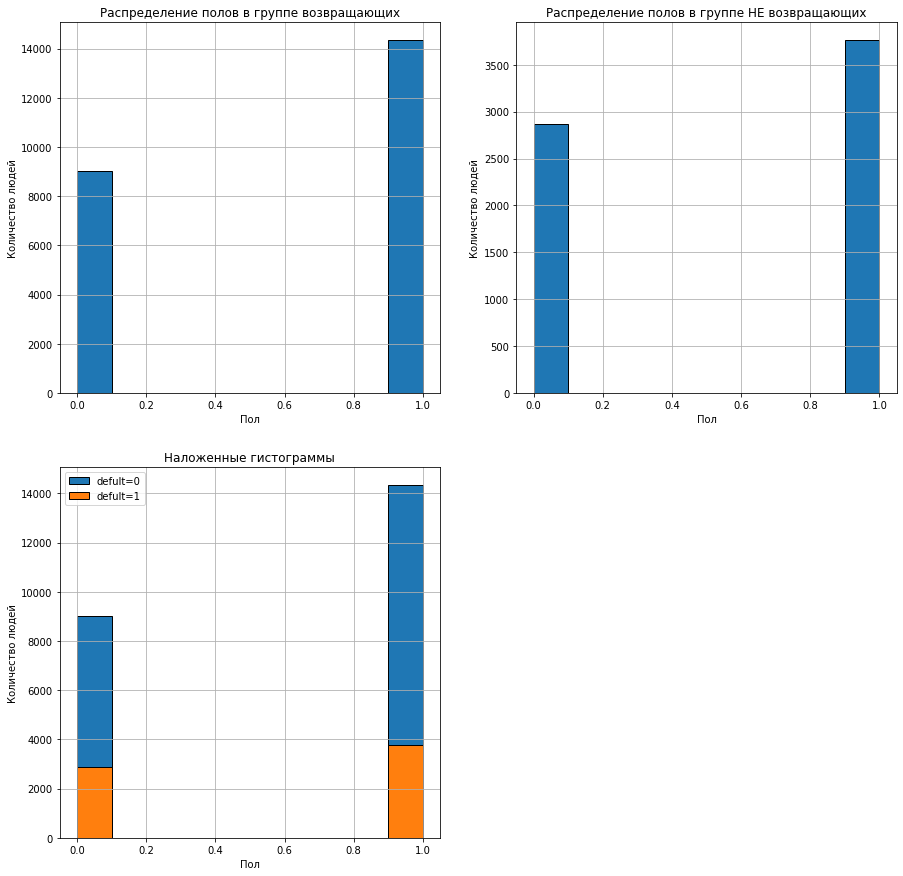

In [10]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.hist(sex_0, edgecolor='k')
plt.xlabel('Пол')
plt.ylabel('Количество людей')
plt.title('Распределение полов в группе возвращающих')
plt.grid()

plt.subplot(2,2,2)
plt.hist(sex_1, edgecolor='k')
plt.xlabel('Пол')
plt.ylabel('Количество людей')
plt.title('Распределение полов в группе НЕ возвращающих')
plt.grid()

plt.subplot(2,2,3)
plt.hist(sex_0, edgecolor='k', label='defult=0')
plt.hist(sex_1, edgecolor='k', label='defult=1')
plt.xlabel('Пол')
plt.ylabel('Количество людей')
plt.title('Наложенные гистограммы')
plt.legend()
plt.grid()

In [11]:
p_sex_0 = sex_0[sex_0 == 1].shape[0] / sex_0.shape[0]
p_sex_1 = sex_1[sex_1 == 1].shape[0] / sex_1.shape[0]

In [12]:
print('Доля мужчин в выборке людей возвращающих кредит:\n', np.round(p_sex_0, 5))
print('Доля мужчин в выборке людей НЕ возвращающих кредит:\n', np.round(p_sex_1, 5))

Доля мужчин в выборке людей возвращающих кредит:
 0.61415
Доля мужчин в выборке людей НЕ возвращающих кредит:
 0.56706


In [13]:
print('Доверительный интервал для доли мужчин, которые возвращают кредит:\n', np.round(proportion_confint(p_sex_0*sex_0.shape[0], sex_0.shape[0]), 5), end='\n\n')
print('Доверительный интервал для доли мужчин, которые НЕ возвращают кредит:\n', np.round(proportion_confint(p_sex_1*sex_1.shape[0], sex_1.shape[0]), 5))

Доверительный интервал для доли мужчин, которые возвращают кредит:
 [0.60791 0.62039]

Доверительный интервал для доли мужчин, которые НЕ возвращают кредит:
 [0.55514 0.57898]


In [14]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [15]:
print('Достигаемый уровень значимости при двусторонней альтернативе\np = ', proportions_diff_z_test(proportions_diff_z_stat_ind(sex_0, sex_1)))
print('Достигаемый уровень значимости при левосторонней альтернативе\np = ', proportions_diff_z_test(proportions_diff_z_stat_ind(sex_0, sex_1), 'less'))
print('Достигаемый уровень значимости при правосторонней альтернативе\np = ', proportions_diff_z_test(proportions_diff_z_stat_ind(sex_0, sex_1), 'greater'))

Достигаемый уровень значимости при двусторонней альтернативе
p =  4.472866521609831e-12
Достигаемый уровень значимости при левосторонней альтернативе
p =  0.9999999999977636
Достигаемый уровень значимости при правосторонней альтернативе
p =  2.2364332608049153e-12


### Значимы ли полученные результаты с практической точки зрения ?
- Да, значимы. Мы узнали, что доля мужчин, в группе людей, которые НЕ возвращают кредиты меньше

# Задание 3
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

In [16]:
edu = credit.EDUCATION
edu_0 = credit[credit.default == 0].EDUCATION
edu_1 = credit[credit.default == 1].EDUCATION

Таблица сопряженности

In [17]:
crosstab = pd.crosstab(credit.EDUCATION, credit.default)
crosstab

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [18]:
partitions = []
for i in range(7):
    p = edu_0[edu_0 == i].shape[0] / (edu_0[edu_0 == i].shape[0] + edu_1[edu_1 == i].shape[0])
    partitions.append(p)
    print('Доля людей по группе образования {}, которые вернут кредит {}'.format(i, np.round(partitions[i], 5)))
partitions = np.array(partitions)

Доля людей по группе образования 0, которые вернут кредит 1.0
Доля людей по группе образования 1, которые вернут кредит 0.80765
Доля людей по группе образования 2, которые вернут кредит 0.76265
Доля людей по группе образования 3, которые вернут кредит 0.74842
Доля людей по группе образования 4, которые вернут кредит 0.94309
Доля людей по группе образования 5, которые вернут кредит 0.93571
Доля людей по группе образования 6, которые вернут кредит 0.84314


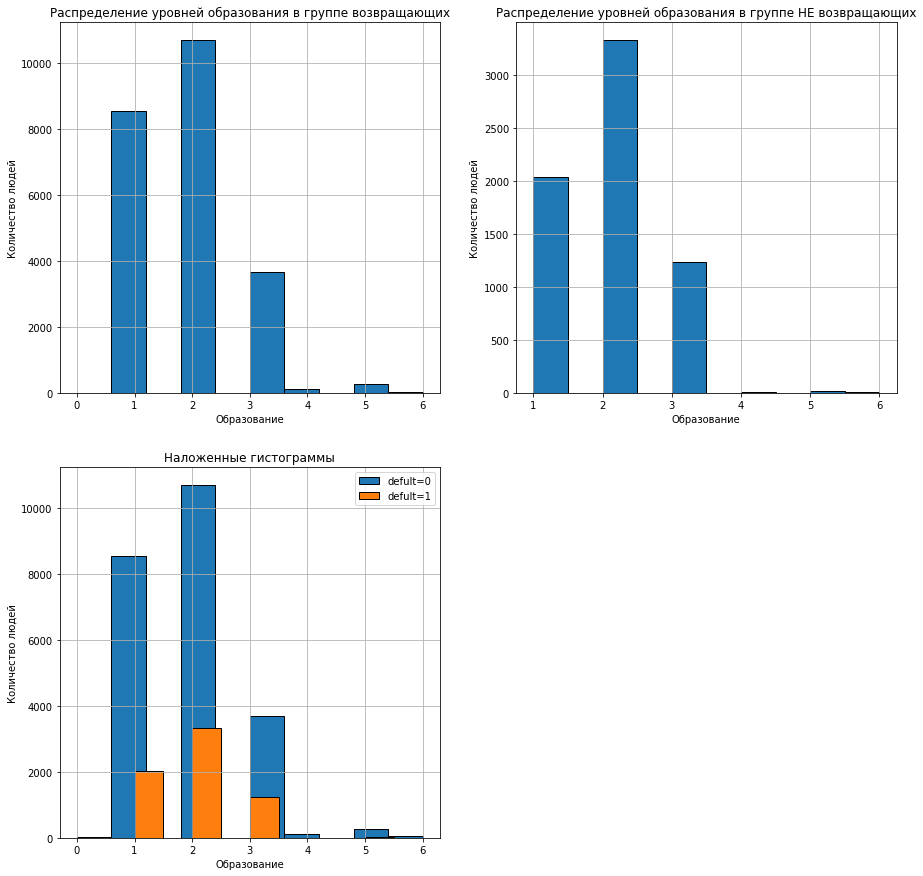

In [19]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.hist(edu_0, edgecolor='k')
plt.xlabel('Образование')
plt.ylabel('Количество людей')
plt.title('Распределение уровней образования в группе возвращающих')
plt.grid()

plt.subplot(2,2,2)
plt.hist(edu_1, edgecolor='k')
plt.xlabel('Образование')
plt.ylabel('Количество людей')
plt.title('Распределение уровней образования в группе НЕ возвращающих')
plt.grid()

plt.subplot(2,2,3)
plt.hist(edu_0, edgecolor='k', label='defult=0')
plt.hist(edu_1, edgecolor='k', label='defult=1')
plt.xlabel('Образование')
plt.ylabel('Количество людей')
plt.title('Наложенные гистограммы')
plt.legend()
plt.grid()

Сначала используем графики и попробуем по ним решить задачу

* H0: Распределение равномерное
* H1: Нулевая гипотеза не верна

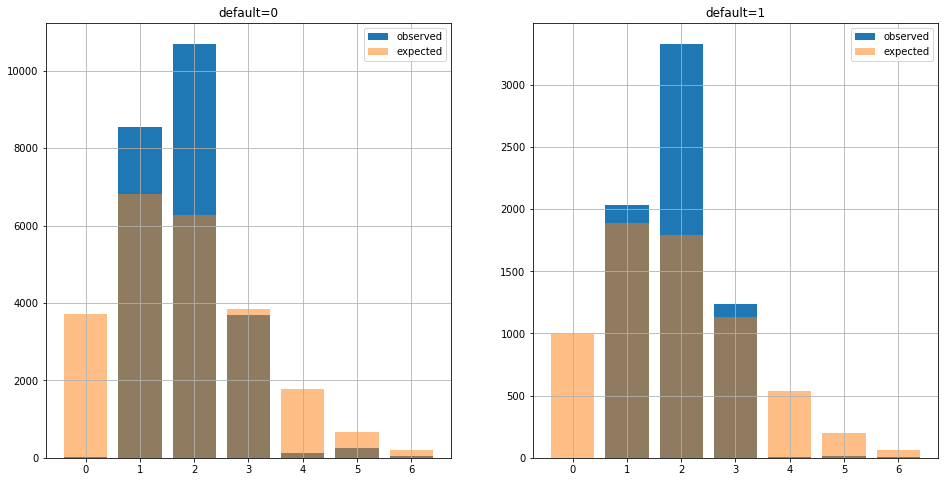

In [20]:
mean_0 = np.mean(edu_0)
observed_frequences_0 = np.bincount(edu_0)
expected_frequences_0 = np.array([len(edu_0)*stats.poisson.pmf(x, mean_0) for x in range(7)])

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.bar(range(7), observed_frequences_0, label='observed', alpha=1)
plt.bar(range(7), expected_frequences_0, label='expected', alpha=0.5)
plt.title('default=0')
plt.legend()
plt.grid()

mean_1 = np.mean(edu_1)
observed_frequences_1 = np.bincount(edu_1)
expected_frequences_1 = np.array([len(edu_1)*stats.poisson.pmf(x, mean_1) for x in range(7)])

plt.subplot(1,2,2)
plt.bar(range(7), observed_frequences_1, label='observed', alpha=1)
plt.bar(range(7), expected_frequences_1, label='expected', alpha=0.5)
plt.title('default=1')
plt.legend()
plt.grid()

Полная сводная таблица

In [21]:
crosstab['expected_0'] = pd.Series(partitions.mean() * (observed_frequences_0 + observed_frequences_1))
crosstab['obs-exp_0'] = crosstab.iloc[:,0] - crosstab.expected_0
crosstab

default,0,1,expected_0,obs-exp_0
EDUCATION,,,,
0,14,0,12.081337,1.918663
1,8549,2036,9134.353886,-585.353886
2,10700,3330,12107.225793,-1407.225793
3,3680,1237,4243.138220,-563.138220
4,116,7,106.143177,9.856823
5,262,18,241.626744,20.373256
6,43,8,44.010586,-1.010586


- Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?
    - Привел все к единому масштабу отскейлив значения с помощью домножения на среднее значение доли людей, которые возвращают кредит
- Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ?
    - Лучший фактор - нулевой индикатор образования, который имеет наибольшую вероятность возврата кредита
- Наоборт, не отдаст долг ?
    - Вторая и третья группы, так как доли людей, которые не возвращают кредит из этих групп самые высокие

# Задание 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [22]:
mar = credit.MARRIAGE
mar_0 = credit[credit.default == 0].MARRIAGE
mar_1 = credit[credit.default == 1].MARRIAGE

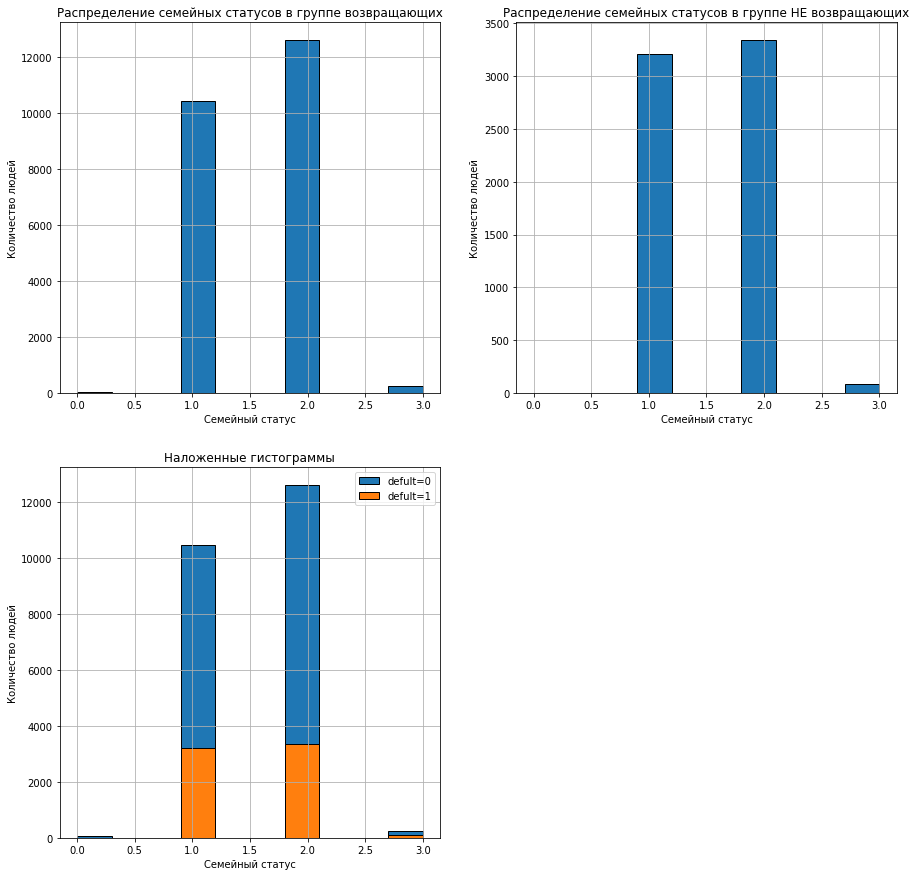

In [23]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.hist(mar_0, edgecolor='k')
plt.xlabel('Семейный статус')
plt.ylabel('Количество людей')
plt.title('Распределение семейных статусов в группе возвращающих')
plt.grid()

plt.subplot(2,2,2)
plt.hist(mar_1, edgecolor='k')
plt.xlabel('Семейный статус')
plt.ylabel('Количество людей')
plt.title('Распределение семейных статусов в группе НЕ возвращающих')
plt.grid()

plt.subplot(2,2,3)
plt.hist(mar_0, edgecolor='k', label='defult=0')
plt.hist(mar_1, edgecolor='k', label='defult=1')
plt.xlabel('Семейный статус')
plt.ylabel('Количество людей')
plt.title('Наложенные гистограммы')
plt.legend()
plt.grid()

Составим таблицу сопряженности для категоритальных выборок и посчитаем коэффициент Крамера, который будет равен 0 при полном отсутствии взаимосвяза и 1 при совпадении переменных

In [24]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

confusion_matrix = np.empty((len(mar.value_counts()), 2))
for i in range(len(mar.value_counts())):
    confusion_matrix[i, 0] = len(mar_0.loc[mar_0 == i])
    confusion_matrix[i, 1] = len(mar_1.loc[mar_1 == i])

print('Coeff V Cramer =', np.round(cramers_stat(confusion_matrix), 5))

Coeff V Cramer = 0.03448


Коэффициент близок к нулю, значит, прямой связи

# Задание 5
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

Посмотрим на графики. Даже по ним уже понятно, что это не одно и то же распределение, возможно, есть сдвиг

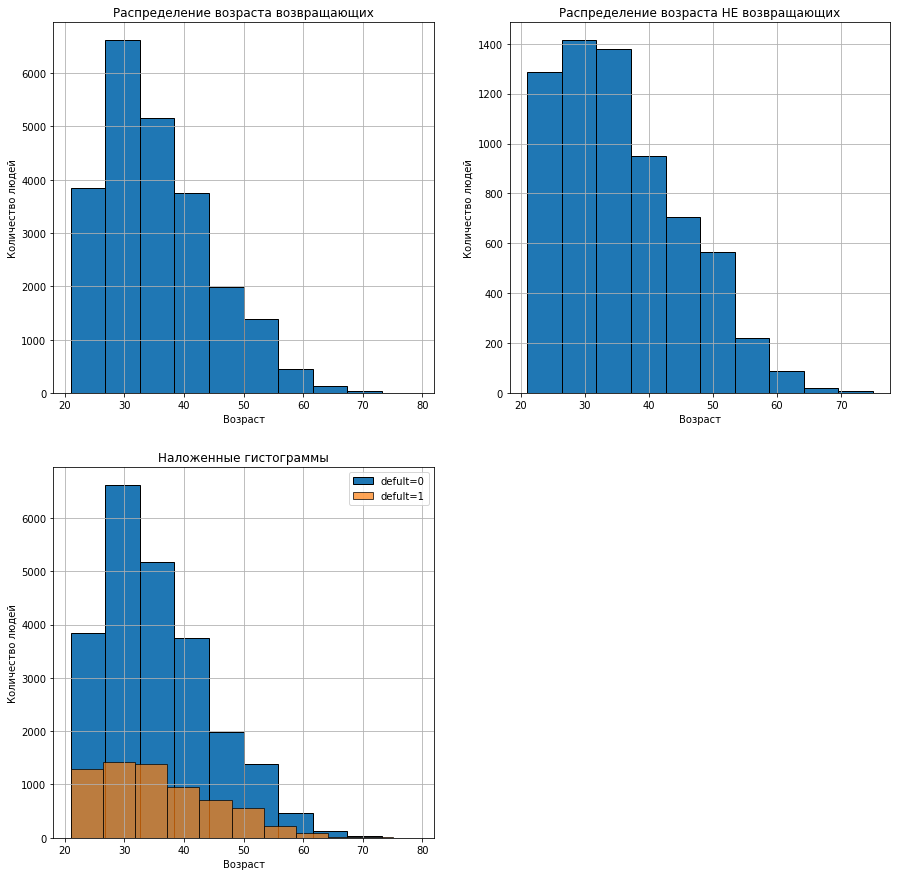

In [25]:
age_0 = credit[credit.default == 0].AGE
age_1 = credit[credit.default == 1].AGE
m0 = age_0.median()
m1 = age_1.median()

plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.hist(age_0, edgecolor='k')
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.title('Распределение возраста возвращающих')
plt.grid()

plt.subplot(2,2,2)
plt.hist(age_1, edgecolor='k')
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.title('Распределение возраста НЕ возвращающих')
plt.grid()

plt.subplot(2,2,3)
plt.hist(age_0, edgecolor='k', label='defult=0', alpha=1)
plt.hist(age_1, edgecolor='k', label='defult=1', alpha=0.7)
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.title('Наложенные гистограммы')
plt.legend()
plt.grid()

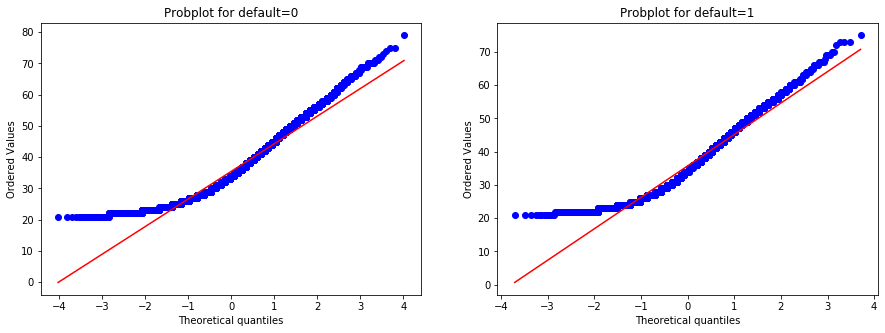

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

stats.probplot(age_0, plot=ax1)
ax1.title.set_text('Probplot for default=0')
stats.probplot(age_1, plot=ax2)
ax2.title.set_text('Probplot for default=1')

Воспользуемся функциями из задания 1

* H0: Медианные значения равны
* H1: Медианные значения отличаются

In [27]:
age_medians_0 = list(map(np.median, get_bootstrap_samples(age_0.values, 1000)))
age_medians_1 = list(map(np.median, get_bootstrap_samples(age_1.values, 1000)))

print('Выборочная медиана возраста, кто отдает кредиты:', m0)
print('Выборочная медиана возраста тех, кто НЕ отдает кредиты:', m1)
print ("95% confidence interval for the age median default=0:",  stat_intervals(age_medians_0))
print ("95% confidence interval for the age median default=1:",  stat_intervals(age_medians_1))

Выборочная медиана возраста, кто отдает кредиты: 34.0
Выборочная медиана возраста тех, кто НЕ отдает кредиты: 34.0
95% confidence interval for the age median default=0: [34. 34.]
95% confidence interval for the age median default=1: [34. 35.]


Интервалы пересекаются, однозначный вывод по этому признаку сделать нельзя, медианы равны

* H0: Выборки получены из одного распределения
* H1: Распределения выборок различаются сдвигом

In [28]:
print('Достигаемые уровни значимости при изменении количества перестановок:', end='\n\n')
for i in range(100, 1001, 100):
    print('\tp = {},\t max permutations = {}'.format(np.round(permutation_test(age_medians_0, age_medians_1, i), 5), i))

Достигаемые уровни значимости при изменении количества перестановок:

	p = 0.01,	 max permutations = 100
	p = 0.005,	 max permutations = 200
	p = 0.00333,	 max permutations = 300
	p = 0.0025,	 max permutations = 400
	p = 0.002,	 max permutations = 500
	p = 0.00167,	 max permutations = 600
	p = 0.00143,	 max permutations = 700
	p = 0.00125,	 max permutations = 800
	p = 0.00111,	 max permutations = 900
	p = 0.001,	 max permutations = 1000


Даже при 100 перестановках мы можем отвергнуть нулевую гипотезу на уровне значимости 0.05. Практическое значение большое, мы знаем, что 25-40 наши любимые возрасты, чтобы кому-нибудь впихнуть кредит хехехе

## Спасибо за внимание!